# Matrizes para caminhada quântica na malha bidimensional

por 

Franklin Marquezino  
Universidade Federal do Rio de Janeiro  
URL: <http://www.cos.ufrj.br/~franklin>  

Em desenvolvimento!

Nesse arquivo vou descrever as matrizes que serão necessárias para nossa simulação. Provavelmente, você já acompanhou o IPython Notebook referente à simulação no caso unidimensional, portanto podemos continuar de onde paramos.

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [3]:
import scipy.sparse as spm

In [4]:
%matplotlib inline

In [5]:
size = 201 # Tamanho do lado da malha
verbose = False # Define se alguns prints devem ser ativados

if size>10 and verbose:
    print('Cuidado! Algumas saídas podem ficar ilegíveis para esse tamanho de malha.')
    print('Sugiro definir verbose=False ou diminuir a malha.')

## 1. Definições do espaço de Hilbert

De acordo com o primeiro postulado, o estado do caminhante quântico deve ser um vetor unitário num espaço de Hilbert. Em nosso exemplo, consideramos que o caminhante ocupa uma *posição* no grafo "malha bidimensional" com número de vértices (nós) igual ao quadrado de `size`. Portanto, o espaço de Hilbert associado a posição é $\mathcal{H}_\mbox{P}$ de dimensão igual ao quadrado de `size`. A base de $\mathcal{H}_\mbox{size}$ pode ser denotada por $\{ | x \rangle : 0 \leq x < \mbox{size}^2 \}$, ou de forma mais intuitiva, por $\{ | x,y \rangle : 0 \leq x,y < \mbox{size} \}$.

Como sabemos, o caminhante quântico discreto no tempo ainda precisa de um grau de liberdade adicional, além da posição. Esse grau de liberdade nós chamamos de *moeda*, semelhantemente ao que estudamos no caso unidimensional. O espaço de Hilbert associado a moeda é $\mathcal{H}_\mbox{M}$ de dimensão igual a 4. (Note que dessa vez temos quatro resultados possíveis para o "lançamento da moeda": o caminhante pode ir para a esquerda, para a direita, para cima ou para baixo.) A base de $\mathcal{H}_\mbox{M}$ pode ser denotada por $\{ | m \rangle : 0 \leq m < 4 \}$, ou de forma mais intuitiva, por $\{ | m, n \rangle : 0 \leq m, n \leq 1 \}$.

De acordo com o terceiro postulado da mecânica quântica, o estado do caminhante é um vetor unitário no espaço $\mathcal{H}_\mbox{M} \otimes \mathcal{H}_\mbox{P}$. Ou seja, é um vetor que num instante de tempo $t$ qualquer pode ser escrito como
$$| \Psi (t) \rangle = \sum_{m,n=0}^{1} \sum_{x,y=0}^{\mbox{size}-1} \psi_{m,n;x,y}(t) | m,n \rangle \otimes | x,y \rangle,$$
com $\psi_{m;x} \in \mathbb{C}$.
Para que esse vetor seja unitário, precisamos que $\sum_{m,n}\sum_{x,y} |\psi_{m,n;x,y}(t)|^2 = 1.$

Vejamos como fica isso no Python! Nosso estado inicial será 
$$| \Psi (0) \rangle = \left(\dfrac{ (|0\rangle + i|1\rangle)\otimes(|0\rangle + i|1\rangle) }{2} \right) \otimes | \frac{\mbox{size}}{2},\frac{\mbox{size}}{2} \rangle,$$
ou seja, a moeda é uma superposição dos quatro estados possíveis; e a posição é o "meio" da malha. Mais tarde, você pode trocar essa condição inicial e re-executar o notebook para ver como ela influencia o resultado final.

In [6]:
coinState = np.array([0.5, 0.5j, 0.5j, -0.5], dtype=complex)
print(coinState)

[ 0.5+0.j   0. +0.5j  0. +0.5j -0.5+0.j ]


In [7]:
positionState = np.zeros(size**2, dtype=complex)
positionState[int(size**2/2)] = 1.0

""" Para ativar os prints abaixo, a varíavel 'verbose' deve ter sido definida como True. Isso só deve ser feito
    juntamente com um valor pequeno para a variável size; digamos, size=10. Caso contrário, a saída ficará ilegível. 
    Recomendo que você execute essa seção do notebook pelo menos uma vez com os prints ativados, para ajudar no
    entendimento. Alguns gráficos a partir da próxima seção, entretanto, ficarão legíveis somente com valores altos 
    em size. """

if verbose:
    print(positionState)

In [8]:
Psi = np.kron(coinState, positionState)

if verbose:
    print(Psi)

Vamos confirmar que a norma de $| \Psi \rangle$ é igual a 1. Ficamos satisfeitos se for um número muito próximo de 1, levando em consideração que pode haver erros de arredondamento típicos dos cálculos numéricos.

In [9]:
np.linalg.norm(Psi)

1.0

Para saber a distribuição de probabilidades na posição do caminhante, precisamos aplicar o quarto postulado da mecânica quântica. Você pode encontrar detalhes na minha tese de doutorado. Por enquanto, podemos resumir no seguinte. A probabilidade de, no instante $t$, realizar uma medição e encontrar o caminhante na posição $x$, é dada por
$$p(x, t) = \sum_{m=0}^{1} |\psi_{m;x}(t)|^2.$$

Como vamos implementar isso no Python? Precisamos fazer um somatório fixando a posição e variando a moeda. No entanto, depois que aplicamos o produto de Kronecker, nosso vetor de estado ficou *aparentemente* misturado. Ou seja, só tem *um* índice para percorrer. Complicado? Nem tanto. Se analisarmos com cuidado como funciona o produto de Kronecker, veremos que podemos identificar precisamente quais entradas do vetor correspondem ao estado da moeda $m=0$, e quais correspondem ao estado da moeda $m=1$. Fica mais fácil ainda se reorganizarmos o nosso vetor, usando o comando `reshape` do Numpy. Se você tiver definido a variável `verbose` como `True`, poderá ver o comando `reshape` em funcionamento logo abaixo:

In [10]:
if verbose:
    print('Assim é o vetor: \n', Psi)
    
    print('\nReorganizando as entradas (sem alterar os valores) ele vai ficar assim: ')
    Psi = Psi.reshape((2,2,size,size))
    print(Psi)
    print('Esse formado facilita o cálculo das probabilidades na malha 1D.')
    
    print('\nA qualquer momento posso voltar ao que tínhamos antes. Veja: ')
    Psi = Psi.reshape((4*size**2,))
    print(Psi)

Agora sim, usando essa ideia fica fácil calcular as probabilidades no Python! Vejamos:

In [11]:
def get_prob(stateVector, posx, posy):
    stateVector = stateVector.reshape((2,2,size,size))
    prob = np.abs(stateVector[0, 0, posx, posy])**2 + np.abs(stateVector[0, 1, posx, posy])**2 +\
            np.abs(stateVector[1, 0, posx, posy])**2 + np.abs(stateVector[1, 1, posx, posy])**2
    stateVector = stateVector.reshape((4*size**2,))
    return prob

O caminhante inicialmente está localizado no meio da linha, pois assim o definimos. Portanto, a probabilidade de encontrá-lo nessa posição deve ser 1. Vejamos:

In [13]:
get_prob(Psi, size//2, size//2)

1.0

E a probabilidade de encontrá-lo em qualquer outra posição deve ser 0. Vejamos:

In [14]:
get_prob(Psi, 0, 0)

0.0

Vamos agora plotar o gráfico da distribuição de probabilidades.

In [134]:
def get_pdf(stateVector):
    """ Returns the probability distribution function (pdf) of
    a given state vector. """
    stateVector = stateVector.reshape((2,2,size,size))
    pdf = np.sum( np.sum(np.abs(stateVector)**2, axis=0), axis=0)
    stateVector = stateVector.reshape((4*size**2,))
    return pdf

In [16]:
Prob = get_pdf(Psi)
Prob = Prob.reshape((size, size))

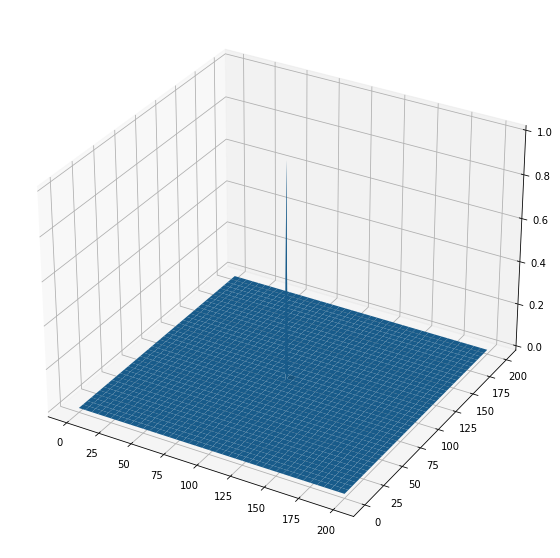

In [17]:
X,Y = np.meshgrid(range(size), range(size))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X,Y, Prob)

Agora que definimos o estado do caminhante, podemos finalmente colocá-lo para caminhar. Para isso, devemos continuar respeitando os postulados da mecânica quântica. Veremos isso na próxima seção.

## 2. Definições da caminhada

A evolução da caminhada quântica se dá por um operador unitário da forma $U = S(C \otimes I)$. A matriz $C$ é o operador moeda, e atua somente no subespaço $\mathcal{H}_M$. Em princípio, $C$ pode ser qualquer operador unitário de dimensão compatível com $\mathcal{H}_M$. Nesse exemplo, vamos tomar $C$ como a matriz de Hadamard. Veja a definição na minha tese de doutorado. A matriz $I$ é a identidade que atua no espaço $\mathcal{H}_P$. A matriz $S$ é o operador deslocamento, que atua no espaço $\mathcal{H}_M \otimes \mathcal{H}_P$.

Vamos definir esses operadores, um de cada vez.

In [18]:
hadamardCoin = np.kron( np.array([[1.0, 1.0],
                                  [1.0, -1.0]]) / np.sqrt(2),
                        np.array([[1.0, 1.0],
                                  [1.0, -1.0]]) / np.sqrt(2))
print(hadamardCoin)

[[ 0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5 -0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]]


A matriz anterior atua somente no espaço moeda. Para termos o operador moeda que atua no espaço composto, ainda precisamos fazer o produto tensorial com o operador identidade que atua no espaço posição. Faremos isso a seguir:

In [19]:
Coin = np.kron(hadamardCoin, np.eye(size*size))

MemoryError: Unable to allocate 195. GiB for an array with shape (16, 1632240801) and data type float64

Excedemos o limite de memória! De fato, veja o comando abaixo. Mesmo para uma matriz **muito menor**, nós já estaríamos gastando cerca de 500MB de memória RAM.

In [20]:
Coin = np.kron(hadamardCoin, np.eye(10*size))
Coin.nbytes

517132800

Portanto, vamos precisar de uma solução mais eficiente. Uma possibilidade seria armazenar somente a `hadamardCoin`, evitando o cálculo explícito do produto de Kronecker. Eu usei essa abordagem no simulador [QWalk](http://www.cos.ufrj.br/~franklin/qwalk/). Aqui, no entanto, vou usar uma abordagem diferente: **matrizes esparsas**!

In [21]:
hadamardSparse = spm.csr_matrix(hadamardCoin)

In [22]:
Coin = spm.kron(hadamardSparse, spm.identity(size*size))

Pronto! Dessa vez conseguimos guardar a matriz inteira na memória. Isso só foi possível pois a matriz possuia muitas entradas iguais a zero, e elas não precisaram ser armazenadas. Veja quantas entradas diferentes de zero nossa matriz possui:

In [23]:
Coin.nnz

646416

Compare com o tamanho total da matriz, incluindo as entradas iguais a zero:

In [24]:
Coin.shape

(161604, 161604)

Agora vamos definir o operador deslocamento. Esse operador modifica a posição de forma dependente da moeda. A estrutura dele, portanto, é um pouco mais complicada. Já vimos que nossa moeda pode ser representada, de forma bastante intuitiva, por dois qubits, $|m,n\rangle$. Essa representação é útil pois permite uma descrição muito sucinta para o operador deslocamento: se o qubit for zero, move-se no sentido positivo; se o qubit for um, move-se no sentido negativo; isso para cada direção separadamente. Ou seja,
$$S|m,n\rangle |x,y\rangle = |m,n\rangle |x + (-1)^m, y + (-1)^n\rangle,$$
para $m,n\in\{0,1\}$, e para $0< x,y < \mbox{size-1}$. Os contornos também devem ser tratado como casos à parte, como fizemos na caminhada unidimensional. Tudo isso que estou descrevendo aqui poderia ser reescrito de diversas outras formas. As únicas restrições são: que o operador no final seja unitário; e que descreva movimentos do caminhante de um sítio até um dos sítios vizinhos. Sugiro que leia minha tese de doutorado para conhecer outros operadores de deslocamento possíveis.

In [25]:
# Não precisei dessas funções dessa vez, mas vou deixá-las aqui por enquanto pois podem ser úteis no futuro.
# Por favor, desconsidere essa célular e vá para a próxima
def index_to_coord(x):
    return np.array([x//size , x%size])

def coord_to_index(x,y):
    return x*size + y

In [26]:
#ainda está muito ineficiente!
Shift = spm.lil_matrix((4*size**2, 4*size**2), dtype=complex)

for x in range(0,size):
    for y in range(0, size):
        for m in [0,1]:
            for n in [0,1]:
                linha = ((m*2 + n)*size + x)*size + y
                coluna = ((m*2 + n)*size + (x+(-1)**m)%size )*size + (y+(-1)**n)%size
                Shift[linha,coluna] = 1.0

Agora sim, temos tudo que precisamos para definir o operador de evolução $U$.

In [27]:
U = Coin*Shift

O Scipy permite vários tipos de armazenamento de matrizes esparsas. Vou usar o formato CSR pois creio que será provavelmente mais eficiente para operações de multiplicação matriz-vetor. (Mas não fiz nenhum teste de eficiencia, e não é o objetivo desse notebook.)

In [28]:
U = spm.csr_matrix(U)

## 3. Simulação da caminhada

Para simular a caminhada quântica na reta, defina o número de passos por meio da variável `tempo` abaixo. Se quiser, você pode voltar ao comando em que definimos o estado inicial do caminhante, e pode modificá-lo para testar diferentes cenários. Dado que o caminhante inicialmente encontrava-se no estado $|\Psi (0) \rangle$, depois de $t$ passos da caminhada ele estará no estado $|\Psi (t)\rangle = U^t |0\rangle.$

In [29]:
tempo = 100

In [30]:
Psit = Psi[:]
for t in range(tempo):
    Psit = U.dot(Psit)
    np.testing.assert_allclose(np.linalg.norm(Psi), 1.0)

In [31]:
Prob = get_pdf(Psit)
Prob = Prob.reshape((size, size))

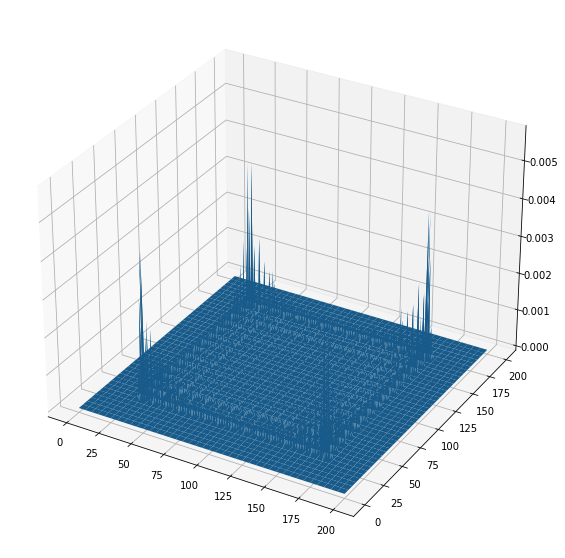

In [32]:
X,Y = np.meshgrid(range(size), range(size))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X,Y, Prob)

Agora vamos refazer a caminhada substituindo a moeda de Hamadamard pela moeda de Grover,
$$C = 2|s_c\rangle\langle s_c| - I,$$
onde
$$|s_c\rangle = \frac{1}{2}\sum_{0\leq m,n \leq 1}{|m,n\rangle}.$$

In [54]:
sc = 0.5*np.ones(4)
groverCoin = 2*np.outer(sc,sc) - np.eye(4)
print(groverCoin)

[[-0.5  0.5  0.5  0.5]
 [ 0.5 -0.5  0.5  0.5]
 [ 0.5  0.5 -0.5  0.5]
 [ 0.5  0.5  0.5 -0.5]]


In [55]:
groverSparse = spm.csr_matrix(groverCoin)
Coin = spm.kron(groverSparse, spm.identity(size*size))
U = Coin*Shift
U = spm.csr_matrix(U)

Vamos modificar o estado inicial também, para o caminhante se espalhar mais rapidamente e simetricamente pela malha. (Você pode testar com outros estados iniciais.)

In [68]:
coinState = np.array([0.5, -0.5, -0.5, 0.5], dtype=complex)
positionState = np.zeros(size**2, dtype=complex)
positionState[int(size**2/2)] = 1.0
Psi = np.kron(coinState, positionState)

In [69]:
np.linalg.norm(Psi)

1.0

In [70]:
tempo = 100

In [71]:
Psit = Psi[:]
for t in range(tempo):
    Psit = U.dot(Psit)
    np.testing.assert_allclose(np.linalg.norm(Psi), 1.0)

In [72]:
Prob = get_pdf(Psit)
Prob = Prob.reshape((size, size))

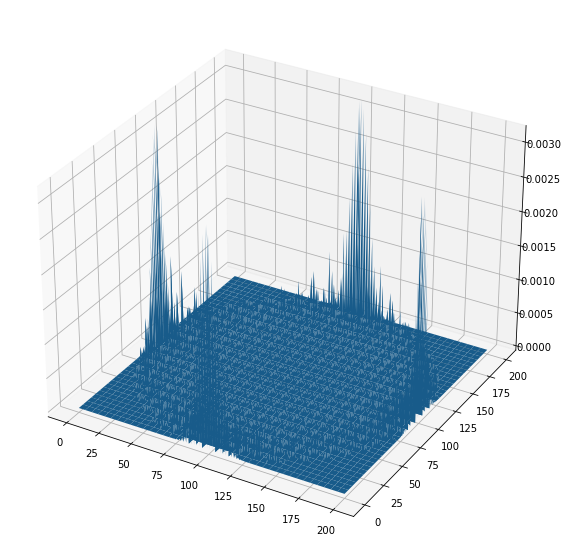

In [73]:
X,Y = np.meshgrid(range(size), range(size))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X,Y, Prob)

## 4. Algoritmo de busca

O nosso problema agora é encontrar um determinado vértice, representado por $|p\rangle$, que satisfaça uma certa propriedade. Por simplicidade, digamos que queremos buscar o vértice que está bem no meio da malha. Se temos uma malha 200 x 200, queremos encontrar então o vértice $|100,100\rangle$. Pode parecer estranho escrever um algoritmo para encontrar algo que já sabemos onde está... mas lembre-se que estamos simplificando as coisas por fins didáticos.

A busca baseada em passeio quântico, obviamente, depende da definição do passeio quântico! Então vamos definir o operador de passeio quântico na malha 2D.

In [267]:
size = 31  # cuidado para não exagerar, senão vai ficar muito lento

In [268]:
# depois seria interessante refazer o código abaixo com matrizes esparsas
sc = 0.5*np.ones(4)
groverCoin = 2*np.outer(sc,sc) - np.eye(4)
Coin = np.kron(groverCoin, np.eye(size*size))

Agora vamos redefinir o operador de deslocamento. Em algoritmos de busca, precisamos do flip-flop shift, ou seja, precisa inverter a moeda juntamente com o deslocamento.

In [269]:
#ainda está muito ineficiente, depois seria interessante melhorar esse código!
Shift = np.zeros((4*size**2, 4*size**2), dtype=complex)

for x in range(0,size):
    for y in range(0, size):
        for m in [0,1]:
            for n in [0,1]:
                linha = ((m*2 + n)*size + x)*size + y
                coluna = (((1-m)*2 + (1-n))*size + (x+(-1)**m)%size )*size + (y+(-1)**n)%size
                Shift[linha,coluna] = 1.0

U = Coin @ Shift  # operador @ em numpy é multiplicação matricial. Note que era diferente quando usávamos matrizes esparsas

O algoritmo vai ser bem parecido com o algoritmo de Grover. Nós precisamos de um oráculo para marcar o vértice procurado. Esse oráculo vai ser do tipo $2|p\rangle \langle p| - I$. Então, no nosso exemplo, vai ser $2|size/2,size/2\rangle \langle size/2,size/2| - I$

In [270]:
p_aux = np.zeros(size)
p_aux[size//2] = 1.0
p = np.kron(p_aux, p_aux)
Oracle = 2*np.kron(np.outer(sc,sc), np.outer(p,p)) - np.eye(4*size**2)

O algoritmo de busca é obtido pelo operador de passeio acrescido de um operador oráculo.

In [271]:
U = U @ Oracle

O estado inicial precisa ser a superposição uniforme.

In [272]:
coinState = np.array([0.5, 0.5, 0.5, 0.5], dtype=complex)
positionState = np.ones(size**2, dtype=complex)/size
Psi = np.kron(coinState, positionState)

In [273]:
np.linalg.norm(Psi)

1.000000000000009

In [274]:
tempo = 8*size   # não precisaria disso tudo, mas assim é útil para visualizar o comportamento do gráfico
Probs = []
Success_probs = []

In [275]:
Psit = Psi[:]
for t in range(tempo):
    Psit = U.dot(Psit)
    np.testing.assert_allclose(np.linalg.norm(Psit), 1.0)
    
    Prob = get_pdf(Psit)
    Prob = Prob.reshape((size, size))
    Probs.append(Prob)
    Success_probs.append(Prob[size//2, size//2])

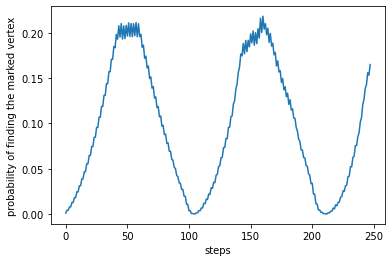

In [276]:
plt.ylabel('probability of finding the marked vertex')
plt.xlabel('steps')
plt.plot(Success_probs)

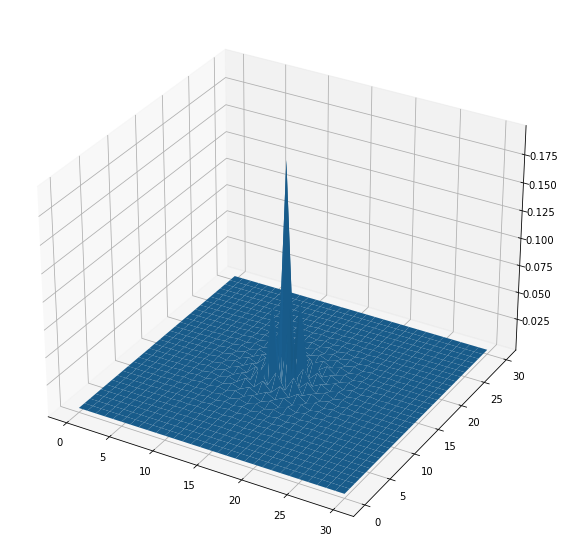

In [277]:
X,Y = np.meshgrid(range(size), range(size))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1, 1, 1, projection='3d')
p = ax.plot_surface(X,Y, Probs[50])

Espero que tenha sido útil. Você pode agora clicar em `Kernel / Restart`, voltar ao início do notebook e repetir os comandos, fazendo modificações de acordo com sua curiosidade.

## Referências

1. Marquezino, F.L., "Análise, simulações e aplicações algorítmicas de caminhadas quânticas". Tese de Doutorado. Laboratório Nacional de Computação Cientícia, Petrópolis, 2010. Disponível em <http://qubit.lncc.br/files/flmarquezino_phd.pdf>.
1. Marquezino, F.L. and Portugal, R., "The QWalk Simulator of Quantum Walks". Computer Physics Communications, Volume 179, Issue 5, pages 359-369, 2008. Preprint disponível em <http://arxiv.org/abs/0803.3459>.
1. Portugal, R., Lavor, C.C., Carvalho, L.M. and Maculan, N., "Uma introdução à Computação Quântica", Notas em Matemática Aplicada, SBMAC, 2004. Disponível em <http://www.sbmac.org.br/boletim/pdf_2004/livro_08_2004.pdf>.